# Assignment 5

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional notes:

* Please note that in this assignment, students are expected to work independently. As a result, no two solutions should look identical in terms of coding;
* You may import any libraries you need to complete the assignment. However, you must implement the model using TensorFlow (do not use PyTorch);
* Follow the same steps/idea as in Assignment 4; the difference here is that you extend a logistic model to more than two classes;
* <span style="color:chocolate"> Focus on the execution of the task rather than model performance </span> (this is how the TA will grade your work);
* Even though the prediction performance for your chosen outcome is low, it doesn't necessarily mean there is something wrong with your implementation. It could also be that the data is not supportive enough for your prediction task... again, focus on the learning opportunity and not the numbers you get;
* Your instructional team has extensive experience developing and running ML models. Often, we encounter situations where a model doesn't perform well on a predictive task. This can happen due to the nature of the data or the need for significant tweaking of variables to achieve good results;
* Do not spend significantly more time on this task than you did on Assignment 4, unless you wish to experiment and learn more.
---

``Objective``
* Perform multiclass classification using logistic regression. <span style="color:chocolate"> You will choose the outcome of interest. </span>

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task. 


``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [1]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras_tuner import HyperParameters

# feel free to import other libraries as needed

import warnings
warnings.filterwarnings('ignore')

2025-02-15 22:21:21.021067: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Define functions

In [2]:
def read_data():
    ''''''
    # Read data
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",
        sep=",",
        encoding='latin-1'
    )
    
    return df

In [3]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15
    
    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

---
### Step 1: Data ingestion

First, we'll initiate the process of discovering the chocolate world by loading the data. Then, to assist with this assignment, we'll start by tidying up the data a little bit. This involves renaming columns and conducting some string preprocessing tasks, which will be handled by the <span style="color:chocolate">clean_data()</span> function mentioned earlier.

In [4]:
df = clean_data(read_data())
print('Shape of data', df.shape)
df.head()

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


### <span style="color:chocolate">Exercise 1:</span> Getting to know the data (5 points)

Answer the following questions:
    
1. How many columns does the dataset contain?
2. How many rows are there in the dataset?
3. What are the column names?
4. List the number of unique values for each column in the data;
5. What are the unique cocoa_percent values?

In [5]:
# YOUR CODE HERE
# columns in dataset
print("number of columns in the dataset: ",df.shape[1])
# number of rows in the dataset
print("number of rows in the dataset: ", df.shape[0])
# Column names
column_names = df.columns.tolist()
print("column names: ",column_names)
# number of unique values for each column 
unique_values_per_column = df.nunique()
print("number of unique values for each column: \n",unique_values_per_column)
# unique cocoa_percent values
print("unique cocoa_percent values",df['cocoa_percent'].unique())

number of columns in the dataset:  9
number of rows in the dataset:  1795
column names:  ['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin']
number of unique values for each column: 
 maker                414
specific_origin     1038
reference_number     440
review_date           12
cocoa_percent         45
maker_location        58
rating                13
bean_type             39
broad_origin         160
dtype: int64
unique cocoa_percent values [ 63.   70.   60.   80.   88.   72.   55.   75.   65.   85.   73.   64.
  66.   68.   50.  100.   77.   90.   71.   83.   78.   74.   76.   86.
  82.   69.   91.   42.   61.   73.5  62.   67.   58.   60.5  79.   81.
  57.   72.5  56.   46.   89.   99.   84.   53.   87. ]


### <span style="color:chocolate">Exercise 2:</span> Choosing the prediction task (5 points)

Now that you’ve explored the data, choose a multiclass outcome (anything except "ratings") that you’re interested in predicting. Note: The outcome should have <span style="color:chocolate">at least 3 classes</span>!

If your chosen outcome variable requires preprocessing, go ahead and handle that below. For instance, you might choose to predict "cocoa_percent". Discretizing it into "0=low," "1=medium," and "2=high" makes it easier to work with/interpret the results.

Your answer here: 

In [6]:
# YOUR CODE HERE
# chosing bean type as multi class outcome
# Handle Missing Values
df['bean_type'] = df['bean_type'].fillna('Unknown')

# Simplify the Bean Types
# Let's create a simplified "bean_type_class" for classification
def categorize_bean_type(bean):
    if 'Blend' in bean:
        return 'Blend'
    elif bean in ['Criollo', 'Forastero', 'Trinitario']:  # Example: handle known types
        return 'Single-origin'
    else:
        return 'Other'

df['bean_type_class'] = df['bean_type'].apply(categorize_bean_type)

# Step 3: Verify the result
print("Unique Bean Types after Categorization:", df['bean_type_class'].unique())
print("Number of unique classes in 'bean_type_class':", df['bean_type_class'].nunique())


Unique Bean Types after Categorization: ['Blend' 'Single-origin' 'Other']
Number of unique classes in 'bean_type_class': 3


---
### Step 2: Data preprocessing

### <span style="color:chocolate">Exercise 3:</span> Prepare data for modeling (20 points)

Following the format of previous assignments, adhere to the following steps as a minimum:

1. Shuffle the dataset;
2. Create training, validation, and test datasets using a 60/20/20 split;
3. Identify the features of interest;
4. Perform necessary cleaning and standarization on the features.

In [15]:
# YOUR CODE HERE
# YOUR CODE HERE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Step 1: Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 2: Create training, validation, and test datasets (60/20/20 split)
X = df[['cocoa_percent', 'maker_location', 'specific_origin']]  # Features of interest
y = df['bean_type_class']  # Target variable

# Split into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 3: Identify features of interest
# Features: cocoa_percent, maker_location, and specific_origin

# Step 4: Clean and Standardize Features

# Handle missing values (if any)
X_train['maker_location'] = X_train['maker_location'].fillna('Unknown')
X_val['maker_location'] = X_val['maker_location'].fillna('Unknown')
X_test['maker_location'] = X_test['maker_location'].fillna('Unknown')

X_train['specific_origin'] = X_train['specific_origin'].fillna('Unknown')
X_val['specific_origin'] = X_val['specific_origin'].fillna('Unknown')
X_test['specific_origin'] = X_test['specific_origin'].fillna('Unknown')

# One-hot encode categorical columns (maker_location and specific_origin)
X_train_encoded = pd.get_dummies(X_train, columns=['maker_location', 'specific_origin'], drop_first=True)
X_val_encoded = pd.get_dummies(X_val, columns=['maker_location', 'specific_origin'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['maker_location', 'specific_origin'], drop_first=True)

# Standardize numerical features (cocoa_percent)
scaler = StandardScaler()
X_train_encoded['cocoa_percent'] = scaler.fit_transform(X_train_encoded[['cocoa_percent']])
X_val_encoded['cocoa_percent'] = scaler.transform(X_val_encoded[['cocoa_percent']])
X_test_encoded['cocoa_percent'] = scaler.transform(X_test_encoded[['cocoa_percent']])

# Verify the result by checking the first few rows of the datasets
print("Training Set:\n", X_train_encoded.head())
print("Validation Set:\n", X_val_encoded.head())
print("Test Set:\n", X_test_encoded.head())



Training Set:
       cocoa_percent  maker_location_Australia  maker_location_Austria  \
1192           0.53                     False                   False   
447           -1.24                     False                   False   
979           -0.27                     False                   False   
178           -0.27                     False                   False   
390            1.67                     False                   False   

      maker_location_Belgium  maker_location_Bolivia  maker_location_Brazil  \
1192                   False                   False                  False   
447                    False                   False                  False   
979                    False                   False                  False   
178                    False                   False                  False   
390                    False                   False                  False   

      maker_location_Canada  maker_location_Colombia  \
1192           

---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 4:</span> Plots (20 points)

In line with the structure of previous assignments, execute the following steps:

1. Generate a minimum of 4 plots to investigate features and outcome within the training dataset;
2. Ensure that each plot includes clear axis labels and titles;
3. Provide commentary on the insights learned from your visualizations.

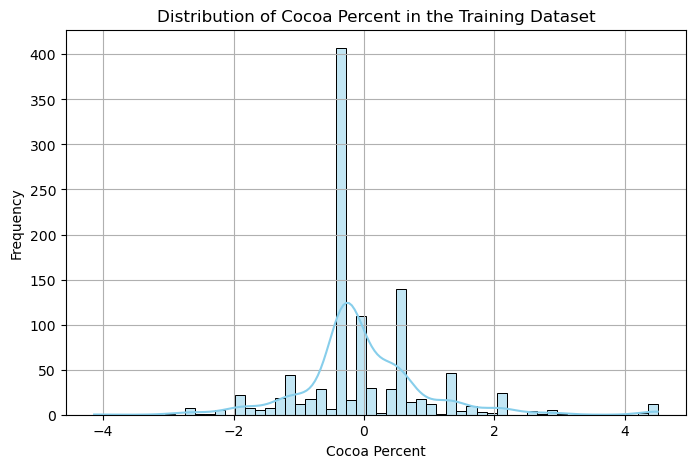

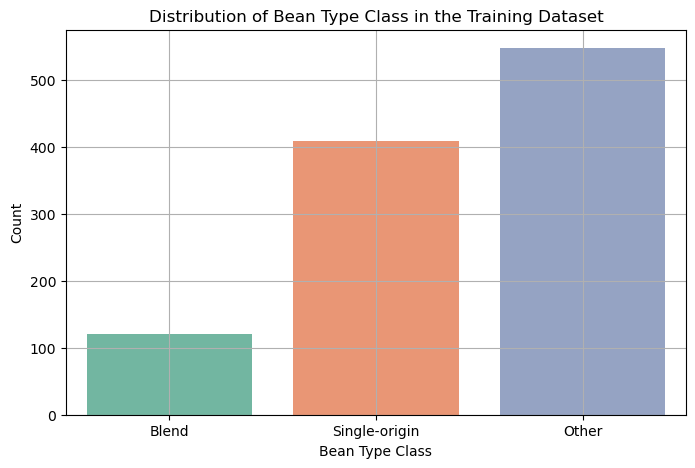

['cocoa_percent' 'maker_location_Australia' 'maker_location_Austria'
 'maker_location_Belgium' 'maker_location_Bolivia' 'maker_location_Brazil'
 'maker_location_Canada' 'maker_location_Chile' 'maker_location_Colombia'
 'maker_location_Costa Rica' 'maker_location_Czech Republic'
 'maker_location_Denmark' 'maker_location_Dominican Republic'
 'maker_location_Ecuador' 'maker_location_England'
 'maker_location_Eucador' 'maker_location_Fiji' 'maker_location_Finland'
 'maker_location_France' 'maker_location_Germany' 'maker_location_Ghana'
 'maker_location_Grenada' 'maker_location_Guatemala'
 'maker_location_Honduras' 'maker_location_Hungary'
 'maker_location_Iceland' 'maker_location_India' 'maker_location_Ireland'
 'maker_location_Israel' 'maker_location_Italy' 'maker_location_Japan'
 'maker_location_Lithuania' 'maker_location_Madagascar'
 'maker_location_Mexico' 'maker_location_Netherlands'
 'maker_location_New Zealand' 'maker_location_Nicaragua'
 'maker_location_Peru' 'maker_location_Philip

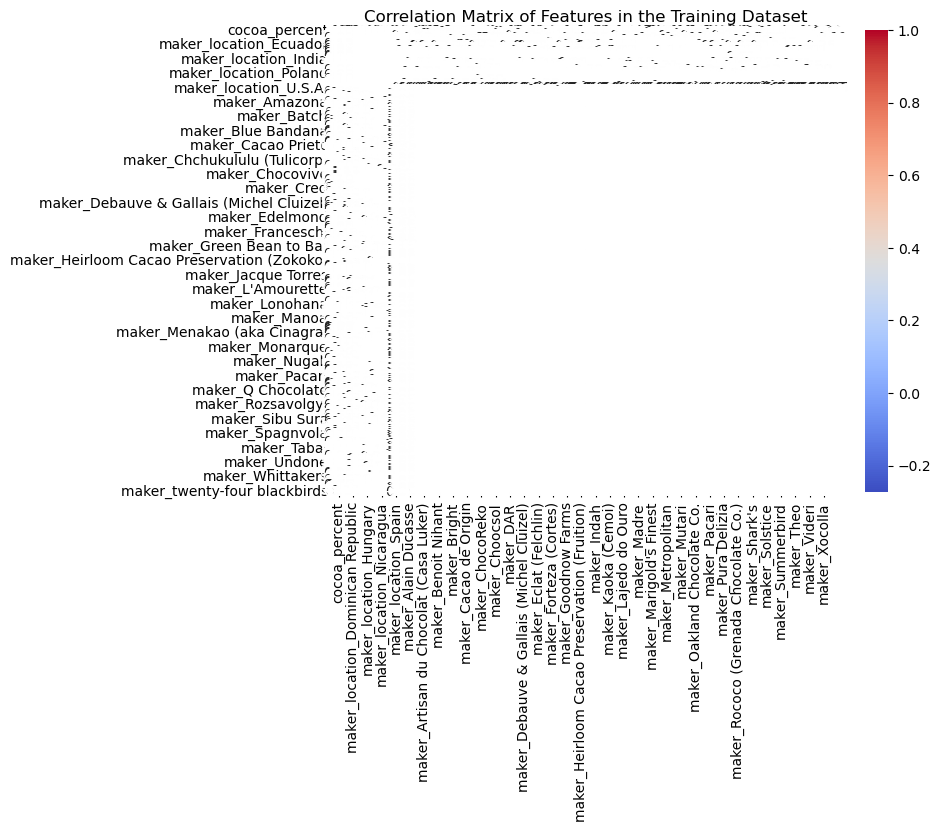

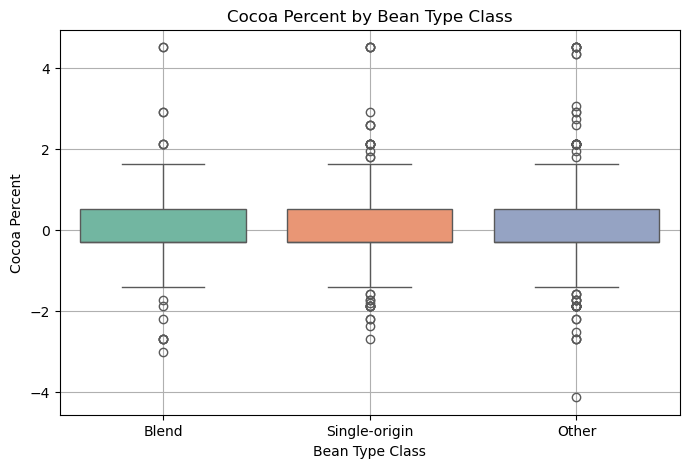

In [ ]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Distribution of 'cocoa_percent' in the training dataset
plt.figure(figsize=(8, 5))
sns.histplot(X_train_encoded['cocoa_percent'], kde=True, color='skyblue')
plt.title('Distribution of Cocoa Percent in the Training Dataset')
plt.xlabel('Cocoa Percent')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Step 2: Distribution of 'bean_type_class' in the training dataset
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train, palette='Set2')
plt.title('Distribution of Bean Type Class in the Training Dataset')
plt.xlabel('Bean Type Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Blend', 'Single-origin', 'Other'])
plt.grid(True)
plt.show()

print(X_train_encoded.columns.values)
# Step 3: Correlation Matrix of the numeric features in the training dataset
plt.figure(figsize=(8, 6))
corr_matrix = X_train_encoded.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features in the Training Dataset')
plt.show()

# Step 4: Box Plot of 'cocoa_percent' by 'bean_type_class'
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y=X_train_encoded['cocoa_percent'], palette='Set2')
plt.title('Cocoa Percent by Bean Type Class')
plt.xlabel('Bean Type Class')
plt.ylabel('Cocoa Percent')
plt.xticks(ticks=[0, 1, 2], labels=['Blend', 'Single-origin', 'Other'])
plt.grid(True)
plt.show()

---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 5:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

1. Implement this baseline and report the accuracy metric on the train data;

2. Implement a function that computes the Log Loss (cross-entropy loss) metric and use it to evaluate this baseline on both the train and validation data. Note: reflect on what you know about the original distribution of classes in your training data (Hint: see Assignment 4 - Exercise 8 and ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example).

In [ ]:
# YOUR CODE HERE

### <span style="color:chocolate">Exercise 6:</span> Improvement over baseline with Tensorflow (10 points)

Use TensorFlow (TF) to train a multiclass logistic regression model much like you did in Assignment 4. The goal here is to build a ML model to improve over the baseline classifier. You have the flexibility to choose which features to include.

With this in mind, complete the following tasks:

1. Build and compile a multiclass classification TF model (call it model_tf). Hint: the activation function, the loss, and the evaluation metric are different compared to the binary logistic regression (see ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example). Set learning_rate = 0.0001 and optimizer = SGD.
2. Train model_tf using the training dataset and pass the validation data for validation. Set num_epochs = 10 and batch_size = 32.
3. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title.

If instructions for any other hyperparameters are not provided here, you are free to select your own or use the default settings.

In [ ]:
# YOUR CODE HERE

---
### Step 5: Hyperparameter tuning

### <span style="color:chocolate">Exercise 7:</span> Choosing hyperparameters (10 points)

1. Fine-tune the **learning rate**, **number of epochs**, and **batch size** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). 

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

In [ ]:
# YOUR CODE HERE

---
### Step 6: Evaluation and generalization

### <span style="color:chocolate">Exercise 8:</span> Compute metrics (10 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate aggregate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras. and the <span style="color:chocolate">np.max()</span> method available in NumPy.

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [ ]:
# YOUR CODE HERE

### <span style="color:chocolate">Exercise 9:</span> Additional metrics (10 points)

Using the test dataset:

1. Plot the confusion matrix. Identify which class the model confuses the most.

2. Determine which class has the lowest precision. What is the precision? Which class is the largest source of false positives?

3. Determine which class has the lowest recall. What is the recall? Which class is the largest source of false negatives?

In [ ]:
# YOUR CODE HERE

----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Following the approach in Assignment 4 - Exercise 12, evaluate whether your model shows any signs of unfairness. Explain your findings and propose suggestions for improvement.

In [ ]:
# YOUR CODE HERE